In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os, sys
import re
import json
import glob
import datetime
from collections import Counter

import pandas as pd
from pandas import DataFrame
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
# Add parent directory to path to import modules from src
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from src.loader import SlackDataLoader
import src.utils as utils
from wordcloud import WordCloud

### Columns we can get from a slack message<br>

message_type, message_content, sender_id, time_sent, message_distribution, time_thread_start, reply_count, reply_user_count, time_thread_end, reply_users

From a single slack message, we can get <br>

1. The message<br>
2. Type (message, file, link, etc)<br>
3. The sender_id (assigned by slack)<br>
4. The time the message was sent<br>
5. The team (i don't know what that is now)<br>
6. The type of the message (broadcast message, inhouse, just messgae)<br>
7. The thread the message generated (from here we can go):<br>
    7.1 Text/content of the message<br>
    7.2 The thread time of the message<br>
    7.3 The thread count (reply count)<br>
    7.4 The number of user that reply the message (count of users that participated in the thread)<br>
    7.5 The time the last thread message was sent <br>
    7.6 The users that participated in the thread (their ids are stored as well)<br>

In [4]:
def get_top_20_user(data, channel='Random'):
    """get user with the highest number of message sent to any channel"""

    data['sender_name'].value_counts()[:20].plot.bar(figsize=(15, 7.5))
    plt.title(f'Top 20 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

    data['sender_name'].value_counts()[-10:].plot.bar(figsize=(15, 7.5))
    plt.title(f'Bottom 10 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

def draw_avg_reply_count(data, channel='Random'):
    """who commands many reply?"""

    data.groupby('sender_name')['reply_count'].mean().sort_values(ascending=False)[:20]\
        .plot(kind='bar', figsize=(15,7.5));
    plt.title(f'Average Number of reply count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_avg_reply_users_count(data, channel='Random'):
    """who commands many user reply?"""

    data.groupby('sender_name')['reply_users_count'].mean().sort_values(ascending=False)[:20].plot(kind='bar',
     figsize=(15,7.5));
    plt.title(f'Average Number of reply user count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_wordcloud(msg_content, week):    
    # word cloud visualization
    allWords = ' '.join([twts for twts in msg_content])
    wordCloud = WordCloud(background_color='#975429', width=500, height=300, random_state=21, max_words=500, mode='RGBA',
                            max_font_size=140, stopwords=stopwords.words('english')).generate(allWords)
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordCloud, interpolation="bilinear")
    plt.axis('off')
    plt.tight_layout()
    plt.title(f'WordCloud for {week}', size=30)
    plt.show()

def draw_user_reaction(data, channel='General'):
    data.groupby('sender_name')[['reply_count', 'reply_users_count']].sum()\
        .sort_values(by='reply_count',ascending=False)[:10].plot(kind='bar', figsize=(15, 7.5))
    plt.title(f'User with the most reaction in #{channel}', size=25);
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

### data frames

In [5]:
ROOT_DIR = '../data/anonymized/'
sl = SlackDataLoader(ROOT_DIR)
dframe = sl.create_dataframe()
reaction_dataframe = sl.create_reaction_data_frame()
mentiones_df = sl.create_mention_data_frames(dframe)
user_names_df = sl.create_users_df()

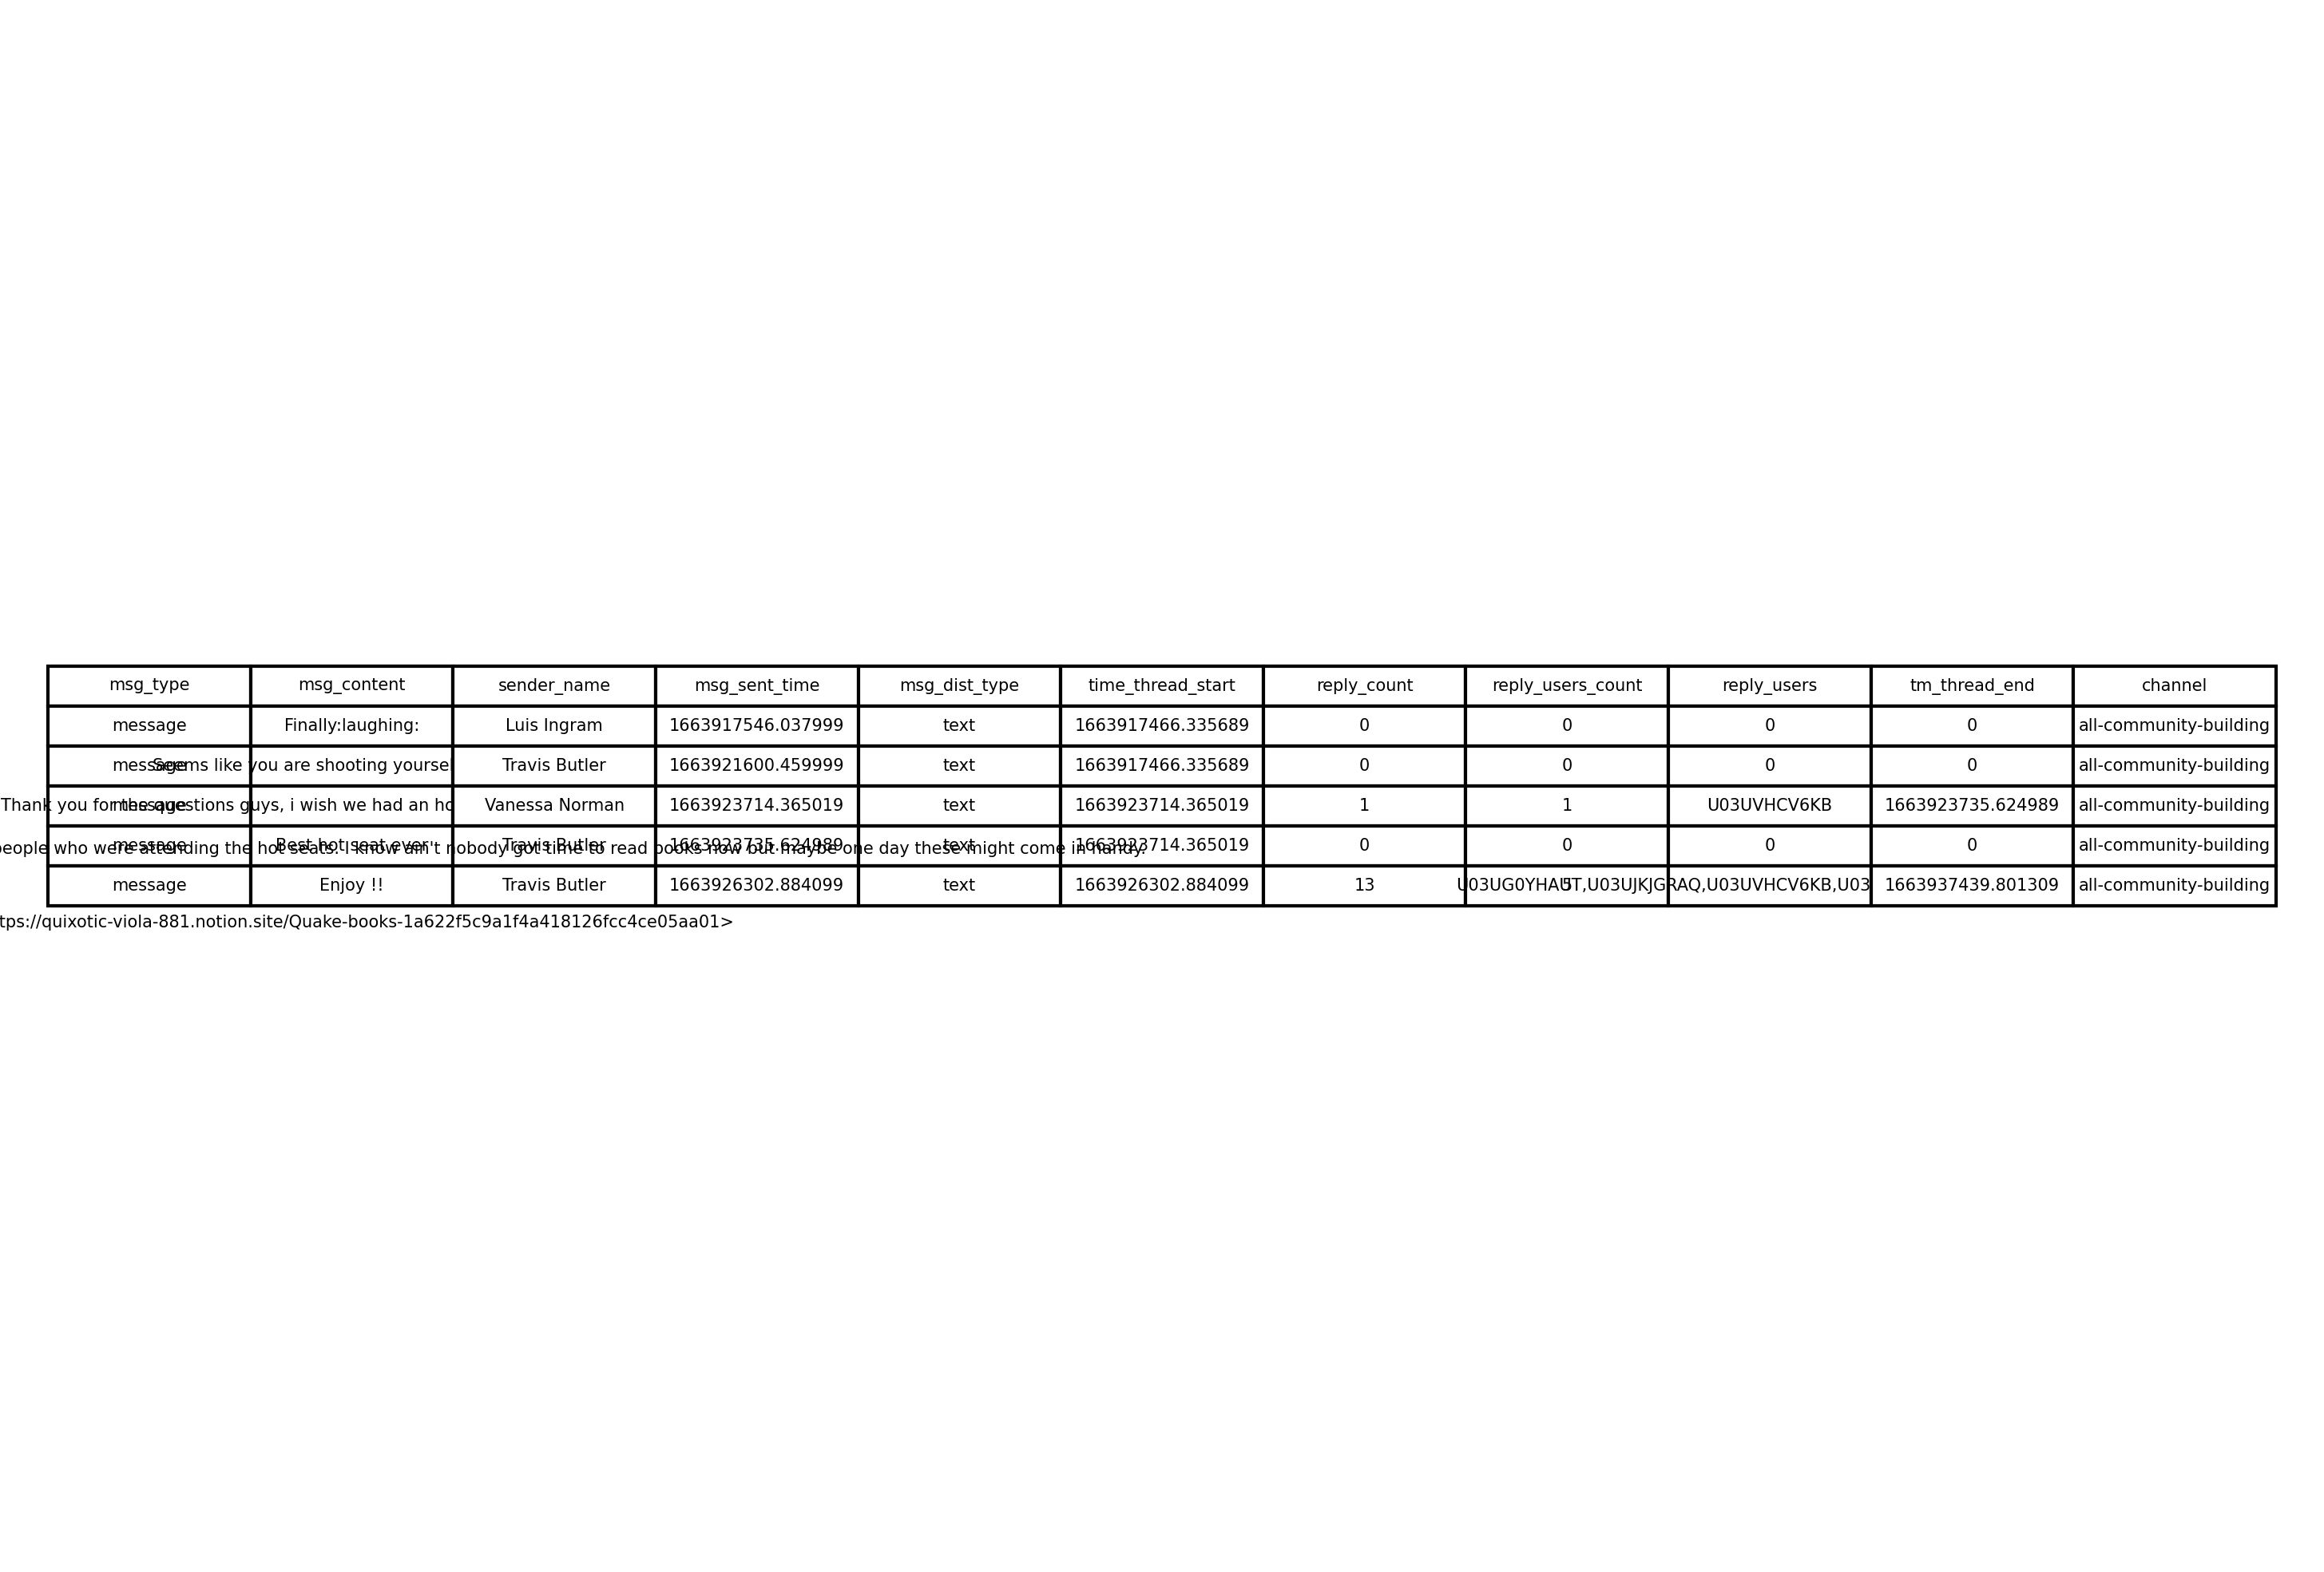

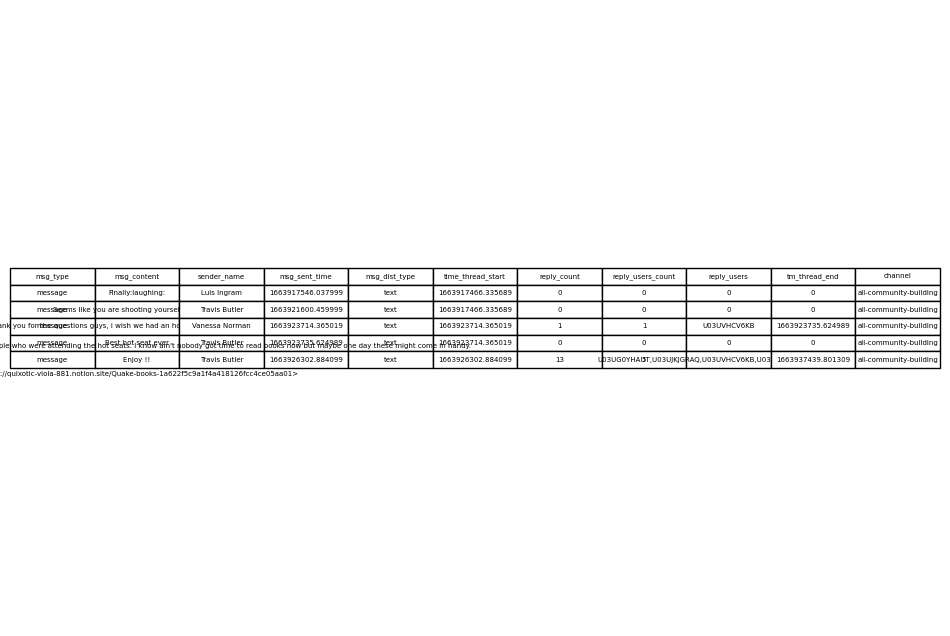

In [14]:
df = dframe.head(5)
# Plot DataFrame
fig, ax = plt.subplots(figsize=(12, 8))
ax.axis('off')  # Turn off axis
table = ax.table(cellText=df.values,
                 colLabels=df.columns,
                 cellLoc='center',
                 loc='center')

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(4)



## Insight Extraction

Below are some useful questions to answer. Feel free to explore to answer other interesting questions that may be of help to get insight about student's behaviour, need, and future performance 

In [190]:
#plot of highest number of reply counts per user
def plot_highest_replies_per_user(data: DataFrame):
    grouped_df = data.groupby('sender_name')['reply_count'].sum()
    grouped_df = grouped_df.sort_values(ascending=False)
    grouped_df.plot(kind='bar', figsize=(15, 7.5))
    
    plt.title('Reply Counts of users')
    plt.xlabel('User')
    plt.ylabel('Number of replies')
    plt.show()



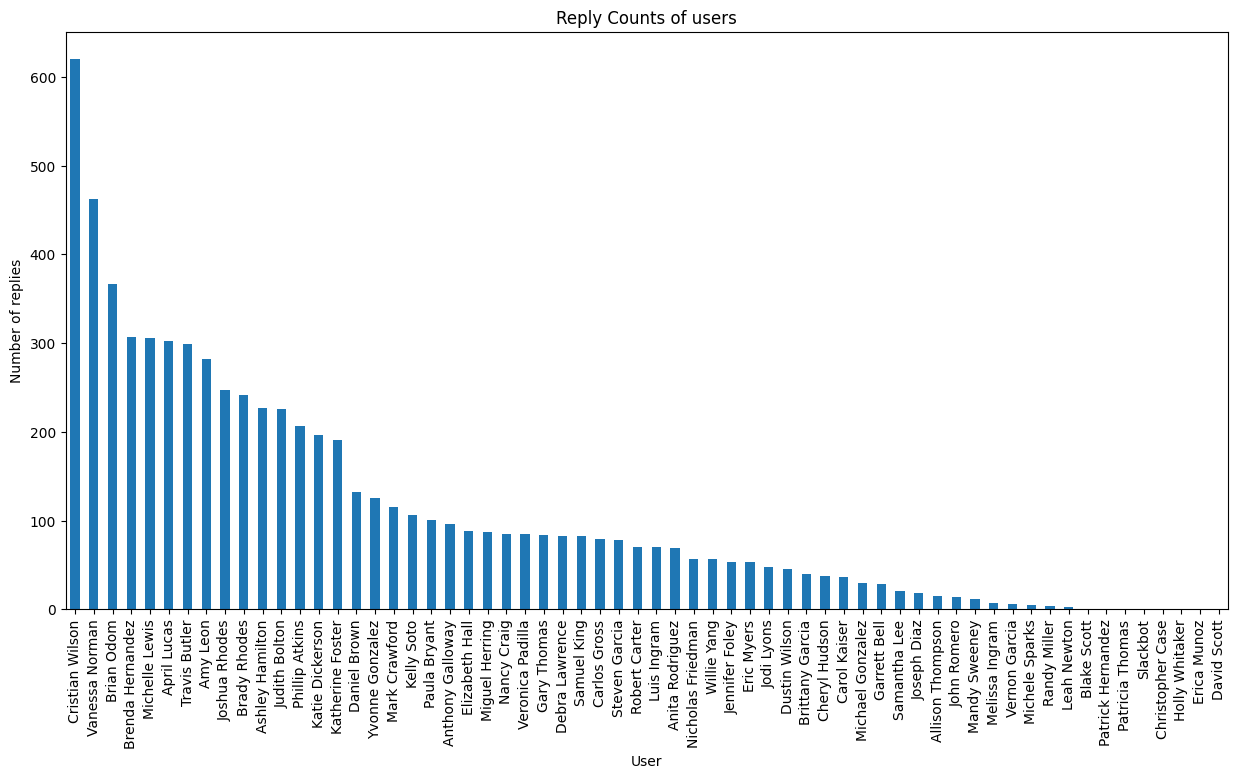

In [191]:
plot_highest_replies_per_user(dframe)

In [149]:
# which user has the highest number of reply counts per message?
def get_user_with_highest_replies(data: DataFrame) -> str:
    row_with_highest_replies = data.loc[data['reply_count'].idxmax()]
    num_replies = row_with_highest_replies['reply_count']
    user_with_highest_replies = row_with_highest_replies['sender_name']
    return user_with_highest_replies

In [150]:
user_with_highest_replies = get_user_with_highest_replies(dframe)
print(user_with_highest_replies)

Brian Odom


In [151]:
# Visualize reply counts per user per channel
def reply_per_user_per_channel(data: DataFrame):
    grouped_df = data.groupby(['channel', 'sender_name'])['reply_count'].sum().unstack()
    grouped_df.plot(kind='bar', figsize=(15, 7.5), stacked=True)
    
    plt.title('Reply Counts per User per Channel')
    plt.xlabel('Channel')
    plt.ylabel('Total Reply Count')
    plt.legend(title='Sender Name', bbox_to_anchor=(1, 1))
    plt.show()

    

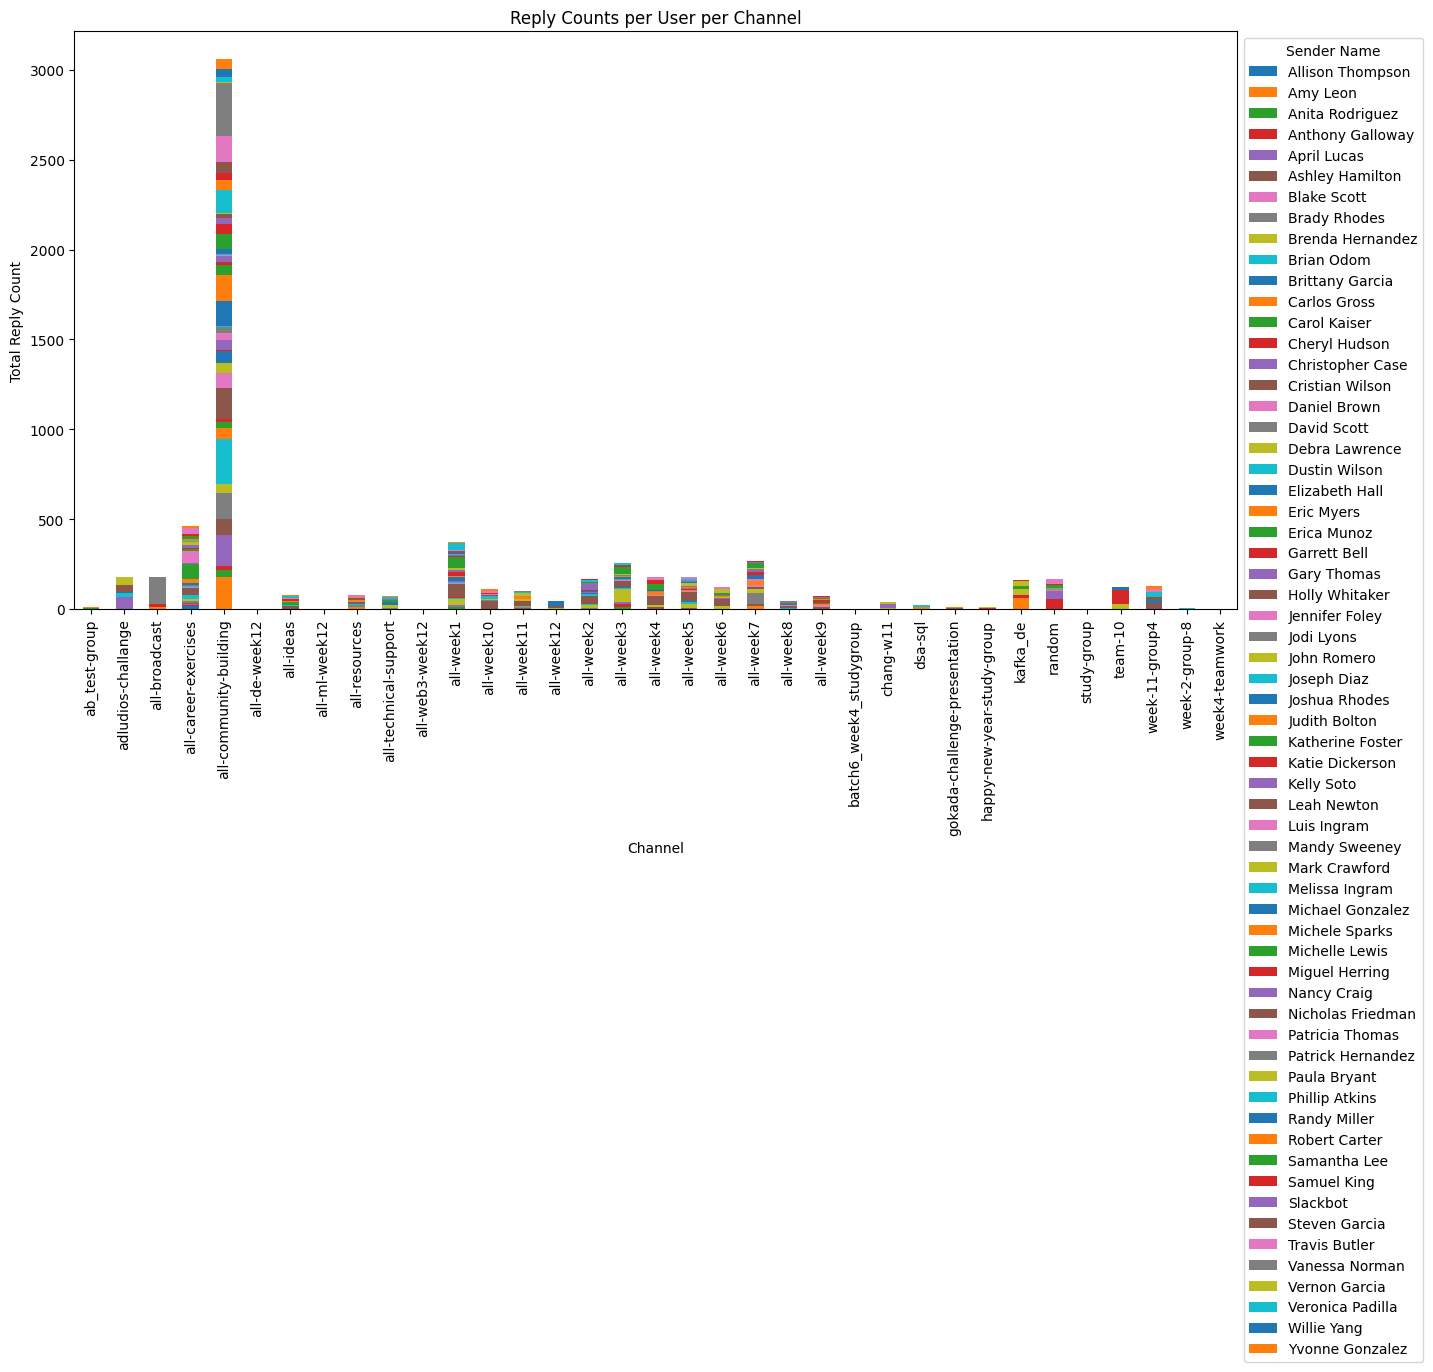

In [152]:
reply_per_user_per_channel(dframe)

In [153]:
def users_with_highest_replies(data: DataFrame):
    users = data.sort_values(by='reply_count', ascending=False).head(10)
    users_replies = users[['sender_name', 'reply_count']]
    return users_replies

In [154]:
#display users with highest replies
users_with_highest_replies(dframe)

,sender_name,reply_count
5799,Brian Odom,75
532,Steven Garcia,63
15010,Brady Rhodes,61
6992,Brian Odom,57
10375,Anthony Galloway,54
11543,Vanessa Norman,45
16438,Ashley Hamilton,44
10155,April Lucas,36
11639,Vanessa Norman,33
3910,Brian Odom,31


In [155]:
#plot of top users with highest replies per message.
def plot_top_users_with_highest_replies(data: DataFrame):
    sorted_data = data.sort_values(by='reply_count', ascending=False)
    top_users = sorted_data.head(10)

    plt.figure(figsize=(16, 8))
    plt.bar(top_users['sender_name'], top_users['reply_count'], color='blue')

    plt.title(f'Top 10 Users with the Highest Replies')
    plt.xlabel('User')
    plt.ylabel('Number of Replies')
    plt.show()


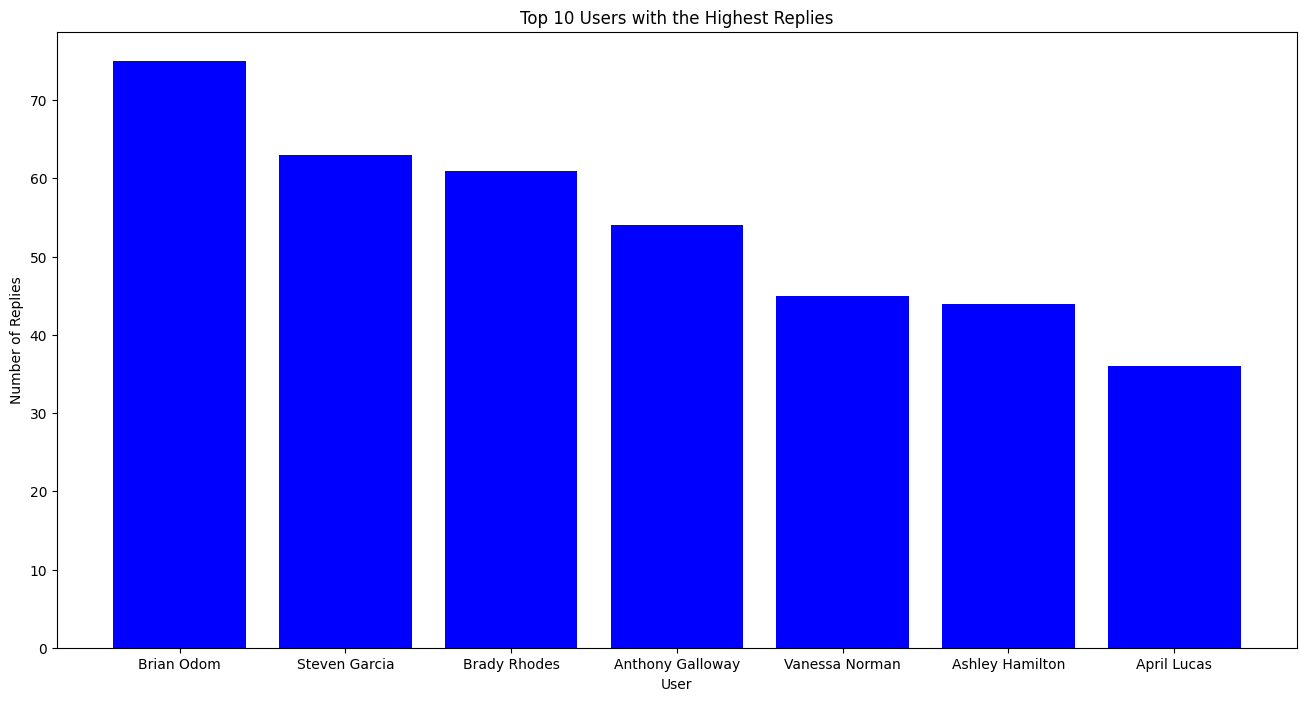

In [156]:
#plot of top users with highest replies
plot_top_users_with_highest_replies(dframe)

In [157]:
#users with low replies
def users_with_lowest_replies(data: DataFrame):
    users = data.sort_values(by='reply_count').head(10)
    user_replies = pd.DataFrame({
        'sender_name': users['sender_name'],
        'replies_count' : users['reply_count']
    })
    return user_replies

In [158]:
users_with_lowest_replies(dframe)

,sender_name,replies_count
0,Luis Ingram,0
11550,Vanessa Norman,0
11551,Vanessa Norman,0
11552,April Lucas,0
11553,Willie Yang,0
11554,Daniel Brown,0
11555,April Lucas,0
11556,Willie Yang,0
11557,Nancy Craig,0
11558,April Lucas,0


In [159]:
#users with highest message count
def users_with_many_messages(data: DataFrame):
    counts = data.groupby('sender_name').size()
    top_users = counts.sort_values(ascending=False).head(10)
    result = pd.DataFrame({
        'sender_name' : top_users.index,
        'message_count' : top_users.values
    })
    return result

In [160]:
users_with_many_messages(dframe)

,sender_name,message_count
0,Vanessa Norman,1288
1,Amy Leon,1150
2,Travis Butler,1075
3,April Lucas,991
4,Brenda Hernandez,843
5,Cristian Wilson,831
6,Phillip Atkins,754
7,Brady Rhodes,641
8,Judith Bolton,574
9,Joshua Rhodes,519


In [161]:
#users with few messages count
def users_with_few_messages(data: DataFrame):
    counts = data.groupby('sender_name').size()
    top_users = counts.sort_values().head(10)
    result = pd.DataFrame({
        'sender_name' : top_users.index,
        'message_count' : top_users.values
    })
    return result

In [162]:
users_with_few_messages(dframe)

,sender_name,message_count
0,Blake Scott,1
1,Erica Munoz,1
2,David Scott,1
3,Holly Whitaker,1
4,Christopher Case,1
5,Slackbot,3
6,Patrick Hernandez,5
7,Randy Miller,7
8,Patricia Thomas,8
9,Leah Newton,10


In [163]:
#get users with highest number of mentions
def users_with_highest_mentions(data: DataFrame):
    counts = data.groupby('user_name').size()
    top_users = counts.sort_values(ascending=False).head(10)
    result = pd.DataFrame({
        'user_name' : top_users.index,
        'mention_count' : top_users.values
    })
    return result

In [164]:
users_with_highest_mentions(mentiones_df)

,user_name,mention_count
0,Vanessa,174
1,Garrett,165
2,Travis,149
3,Amy,143
4,April,139
5,Phillip,111
6,Brady,110
7,Judith,109
8,Brian,102
9,Brittany,101


In [165]:
#get users with lowest mentions
def users_with_lowest_mentions(data: DataFrame):
    counts = data.groupby('user_name').size()
    users = counts.sort_values(ascending=True).head(10)
    result = pd.DataFrame({
        'user_name' : users.index,
        'mention_count' : users.values
    })
    return result

In [166]:
#get lowest mention counts
users_with_lowest_mentions(mentiones_df)

,user_name,mention_count
0,Patrick,2
1,Patricia,2
2,Steven,3
3,Bethany,3
4,Randy,3
5,Carol,3
6,Leah,5
7,Vernon,6
8,Melissa,7
9,Cheryl,11


In [167]:
#users with top 10 reactino count
def users_with_highest_reactions(data: DataFrame):
    users = data.sort_values(by='reaction_count', ascending=False).head(10)
    users_reactions = users[['user_id', 'reaction_count']]
    merged = users_reactions.merge(user_names_df, on='user_id',how='inner')
    return merged[['user_name', 'reaction_count']]

In [168]:
users_with_highest_reactions(reaction_dataframe)

,user_name,reaction_count
0,Garrett,17
1,Garrett,15
2,Katherine,16
3,Joseph,16
4,Willie,16
5,Vanessa,15
6,Vanessa,15
7,Vanessa,13
8,Cristian,14
9,Luis,14


In [169]:
#users with bottome 10 reactino count
def users_with_lowest_reactions(data: DataFrame):
    users = data.sort_values(by='reaction_count').head(10)
    users_reactions = users[['user_id', 'reaction_count']]
    merged = users_reactions.merge(user_names_df, on='user_id',how='inner')
    return merged[['user_name', 'reaction_count']]

In [170]:
users_with_lowest_reactions(reaction_dataframe)

,user_name,reaction_count
0,Vanessa,1
1,Vanessa,1
2,Vanessa,1
3,Vanessa,1
4,Vanessa,1
5,Katherine,1
6,Daniel,1
7,Judith,1
8,Paula,1
9,Phillip,1


In [171]:
def message_with_replies(data: DataFrame):
    df = data.sort_values(by='reply_count', ascending=False)
    return df

In [172]:
#message with top replies
messages = message_with_replies(dframe)
messages.head(10)

,msg_type,msg_content,sender_name,msg_sent_time,msg_dist_type,time_thread_start,reply_count,reply_users_count,reply_users,tm_thread_end,channel
5799,message,<@U03V1AM5TFA> how many crushes you have?,Brian Odom,1668169350.223689,user,1668169350.223689,75,8,"U03V1AM5TFA,U03UUS0MZCZ,U03UG32J3PC,U03UVHCV6K...",1668173595.550369,all-community-building
532,message,First Impression: People think I am older than...,Steven Garcia,1663072090.617319,text,1663072090.617319,63,8,"U03UUR571A5,U03UG32J3PC,U03UFV7TUTV,U03V785NLS...",1663077515.282329,all-community-building
15010,message,1. How do I find my jupyter notebook file in m...,Brady Rhodes,1664916746.043439,rich_text_section,1664916746.043439,61,5,"U03UUR571A5,U03UVHCV6KB,U03U9EJR362,U03UD68RQH...",1664920378.724399,all-week7
6992,message,How many here follow football so much? I think...,Brian Odom,1666700374.650289,text,1666700374.650289,57,10,"U03V5Q9N516,U03V785NLSU,U03UG32J3PC,U03UJN29Y4...",1666709362.373899,all-community-building
10375,message,Ethiopian New year Loading ....,Anthony Galloway,1662400744.293029,text,1662400744.293029,54,3,"U03UG32J3PC,U03UUR571A5,U03UFV7TUTV",1662406508.168569,random
11543,message,Hello\n1. <@U03UVHCV6KB>\n2. <@U03UG5VFN03>\n3...,Vanessa Norman,1667286619.471889,text,1667286619.471889,45,7,"U03UG32J3PC,U03UG0SFHGT,U03UG5VFN03,U03V1AM5TF...",1667308401.183059,all-broadcast
16438,message,<@U03UUR571A5> Solutions to funding account an...,Ashley Hamilton,1666858629.076399,user,1666858629.076399,44,4,"U03UUR571A5,U03UJGP0C68,U03U1FNPEUX,U03UKL27B0R",1666944753.417749,all-week10
10155,message,We had a plan to meet today 2:00 EAT at Friend...,April Lucas,1667700160.574059,text,1667700160.574059,36,4,"U03UG32J3PC,U03UUR571A5,U03UD68RQH3,U03UG0YHAUT",1667713572.552719,random
11639,message,*<!here> REMINDER*:timer_clock:\n\n*Please not...,Vanessa Norman,1665137100.215739,broadcast,1665137100.215739,33,3,"U03UH397319,U03TEPYRM2P,U03V1AM5TFA",1665142057.729989,all-broadcast
3910,message,"the debate was great. We <@U03U1J51VFZ>, <@U03...",Brian Odom,1665057691.571429,text,1665057691.571429,31,12,"U03UUR571A5,U03U1J51VFZ,U03UD68RQH3,U03UJN29Y4...",1665059196.765399,all-community-building


In [173]:
#messages with low replies
messages.tail(10)

,msg_type,msg_content,sender_name,msg_sent_time,msg_dist_type,time_thread_start,reply_count,reply_users_count,reply_users,tm_thread_end,channel
6239,message,hello today is half way of the training right?,Samuel King,1664539244.326919,text,0,0,0,0,0,all-community-building
6240,message,hi!,Kelly Soto,1664539251.163729,text,0,0,0,0,0,all-community-building
6241,message,:face_with_cowboy_hat:,Amy Leon,1664539279.776319,emoji,0,0,0,0,0,all-community-building
6243,message,wait whaat,Judith Bolton,1664539312.881319,text,1664539240.683849,0,0,0,0,all-community-building
6244,message,:star-struck:,Miguel Herring,1664539368.201149,emoji,0,0,0,0,0,all-community-building
6245,message,Hello,Daniel Brown,1664539372.226199,text,0,0,0,0,0,all-community-building
6246,message,so am I:smiley:,Judith Bolton,1664539395.872019,text,1664539308.692519,0,0,0,0,all-community-building
6247,message,:grin:,Daniel Brown,1664539423.816439,emoji,0,0,0,0,0,all-community-building
6248,message,:hugging_face: half (1/2) ...,Debra Lawrence,1664539441.802259,emoji,0,0,0,0,0,all-community-building
17747,message,<https://developer.algorand.org/solutions/mint...,Katie Dickerson,1668359175.400459,link,0,0,0,0,0,all-web3-week12


In [174]:
def messages_with_reactions(data: DataFrame):
    return data.sort_values(by='reaction_count', ascending=False)

In [175]:
messages = messages_with_reactions(reaction_dataframe)

In [176]:
#message with top reactions
messages.head(10)

,reaction_name,reaction_count,reaction_users_count,message,user_id,channel
4675,white_check_mark,17,"U03UG5VFN03,U03UJGP0C68,U03V785NLSU,U03UG0YHAU...","Good morning winners, welcome to week 9 of wee...",U03TEPYRM2P,all-week9
4158,raised_hands,16,"U03U1GHT39V,U03UJN29Y4C,U03UG1RTXAP,U03UG4Q7V4...",Little known fact - all 10 Academy technical t...,U03U93GNNVB,all-broadcast
252,raised_hands,16,"U03UD68RQH3,U03U9EJR362,U03UFV7TUTV,U03U1FNPEU...",,U03U1GHT39V,all-community-building
2105,joy,16,"U03UUR571A5,U03V785NLSU,U03UD68RQH3,U03UD4FEDH...",My reactions when am not finished the task bef...,U03UG0SFHGT,all-community-building
64,rolling_on_the_floor_laughing,15,"U03UG32J3PC,U03U9EJR362,U03U1HAG9TR,U03UJGP0C6...",*Guys <!here>.... Make sure to come back from ...,U03V1AM5TFA,all-community-building
1322,joy,15,"U03V6HMRPGQ,U03U9EJR362,U03UFV7HFNF,U03UVHCV6K...",*Here are some other stories from people that ...,U03V1AM5TFA,all-community-building
4468,raised_hands,15,"U03UG32J3PC,U03V61VGQG0,U03UG0YHAUT,U03UJGRN5E...","Welcome to week6 everyone. By Friday, we’ll be...",U03TEPYRM2P,all-week6
1962,rolling_on_the_floor_laughing,14,"U03UJGP0C68,U03UG4Q7V42,U03UFV7HFNF,U03UG1Z21J...","1- let me open my VPN, where do you want me to...",U03V6HMRPGQ,all-community-building
3432,raised_hands,14,"U03UJGP0C68,U03UG32J3PC,U03UG0SFHGT,U03UG1Z21J...",<!channel>\nThere will be no careers exercise ...,U03TT5KEYCF,all-career-exercises
1723,fire,13,"U03UJGP0C68,U03UJGRN5E0,U03UG1Z21JP,U03U9EJR36...",*HOT SEAT ANNOUNCEMENT! <!here>*\n_*Good morni...,U03V1AM5TFA,all-community-building


In [177]:
#message with lowest reactions
messages.tail(10)

,reaction_name,reaction_count,reaction_users_count,message,user_id,channel
2150,grinning,1,U03V1AM5TFA,He gonna lose his language,U03UG4Q7V42,all-community-building
2151,raised_hands,1,U03U1HAG9TR,TGIF?,U03UG4Q7V42,all-community-building
2152,smile,1,U03U1HAG9TR,<@U03U1HAG9TR> i can't wait for your CBS response,U03V1AM5TFA,all-community-building
2153,fire,1,U03V6HMRPGQ,My life would be Gladiator.,U03U93GNNVB,all-community-building
2155,raised_hands::skin-tone-4,1,U03UG4Q7V42,"My life would be irone man, I really see my se...",U03V6HMRPGQ,all-community-building
2156,clap,1,U03UG5VFN03,"My life would be irone man, I really see my se...",U03V6HMRPGQ,all-community-building
2157,raised_hands,1,U03V1AM5TFA,"My life would be ""The Last Kingdom"", never giv...",U03UFV7HFNF,all-community-building
2158,raised_hands::skin-tone-3,1,U03U9EJR362,"My life would be ""The Last Kingdom"", never giv...",U03UFV7HFNF,all-community-building
2159,joy,1,U03V6HMRPGQ,don't forget a billionaire,U03U1HAG9TR,all-community-building
5016,raised_hands,1,U03UVHCV6KB,<@U03UL5LSTG9> has joined the channel,U03UL5LSTG9,data-engineering
